In [1]:
!pip install networkx
!pip install matplotlib
import networkx as nx
import matplotlib.pyplot as plt

# CSC421 Assignment 1 Agents, Search, and CSP 

This assignment notebook explores topics covered in **Chapter 2 - Intelligent Agents**, **Chapter 3 - Searching** and **Chapter 6 - Constraint Satisfication Problems** from the book *Artificial Intelligence: A Modern Approach.* The code provided is based on parts of the aima-code repository but has been modified and simplified for the purposes of the assignment. The notebook is self-contained and other than importing a few common packages you 
don't need to access any additional code. 

You are welcome and actually it can be educational to look at the code at the aima-code repository as well as other code resources you can find on the web. However, make sure you understand any code that you incoporate. 

The assignment structure is as follows - each item is worth 1 point: 

1. Agents (Basic) - Modify the BlindDog agent to sleep after eating (reflex agent->model-based agent) 
2. Agents (Expected) - Change the Environment from a simple 1D environment to a graph-based map environment 
3. Search (Basic) - Input Australia map, run BFS and DFS 
4. Search (Basic) - Print Frontier after each expansion 
5. Search (Expected) RandomSwitch search 
6. Search (Expected) Random generation + measurement 
7. Search (Advanced) Plotting 
8. CSP (Basic): Make example of job scheduling (or some other problem) and run CSP to find solution 
9. CSP (Expected): Translate complex contraint (maybe alldiff or binary <) to set of binary contraints 
10. CSP (Advanced): Implement CSP as a search problem and compare DFS with the CSP solver provided  

The grading will be done in 0.5 increments. 1 point for correct answer, 0.5 points for partial or incorrect 
but reasonable answer and 0.0 for no answer or completely wrong answer. 


We start by defining abstract classes for Things, Agents, and Environments. Then we create a specific Park environment and a specific Agent (Blind Dog) that operates in this environment. 
Once that is done we can simulate how the agent interacts with the environment. 

In [2]:
class Thing:                                                                                        
    """This represents any physical object that can appear in an Environment.                       
    You subclass Thing to get the things you want. Each thing can have a                            
    .__name__  slot (used for output only)."""                                                                                                                                                      
    def __repr__(self):                                                                             
        return '<{}>'.format(getattr(self, '__name__', self.__class__.__name__))                    
                                                                                                                                                                        

In [3]:
class Agent(Thing):
    """An Agent is a subclass of Thing with one required instance attribute 
    (aka slot), .program, which should hold a function that takes one argument,
    the percept, and returns an action. (What counts as a percept or action 
    will depend on the specific environment in which the agent exists.)
    Note that 'program' is a slot, not a method. If it were a method, then the
    program could 'cheat' and look at aspects of the agent. It's not supposed
    to do that: the program can only look at the percepts. An agent program
    that needs a model of the world (and of the agent itself) will have to
    build and maintain its own model. There is an optional slot, .performance,
    which is a number giving the performance measure of the agent in its
    environment."""

    def __init__(self, program=None):
        self.alive = True
        self.holding = []
        self.performance = 0
        self.program = program


In [4]:
class Environment:
    """Abstract class representing an Environment. 'Real' Environment classes
    inherit from this. Your Environment will typically need to implement:
        percept:           Define the percept that an agent sees.
        execute_action:    Define the effects of executing an action.
                           Also update the agent.performance slot.
    The environment keeps a list of .things and .agents (which is a subset
    of .things). Each agent has a .performance slot, initialized to 0.
    Each thing has a .location slot, even though some environments may not
    need this."""

    def __init__(self):
        self.things = []
        self.agents = []

    def thing_classes(self):
        return []  # List of classes that can go into environment

    def percept(self, agent):
        """Return the percept that the agent sees at this point. (Implement this.)"""
        raise NotImplementedError

    def execute_action(self, agent, action):
        """Change the world to reflect this action. (Implement this.)"""
        raise NotImplementedError

    def default_location(self, thing):
        """Default location to place a new thing with unspecified location."""
        return None

    def is_done(self):
        """By default, we're done when we can't find a live agent."""
        return not any(agent.is_alive() for agent in self.agents)

    def step(self):
        """Run the environment for one time step. """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                self.execute_action(agent, action)

    def run(self, steps=1000):
        """Run the Environment for given number of time steps."""
        for step in range(steps):
            if self.is_done():
                return
            self.step()

    def list_things_at(self, location, tclass=Thing):
        """Return all things exactly at a given location."""
        return [thing for thing in self.things
                if thing.location == location and isinstance(thing, tclass)]

    def add_thing(self, thing, location=None):
        """Add a thing to the environment, setting its location. For
        convenience, if thing is an agent program we make a new agent
        for it. (Shouldn't need to override this.)"""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        if thing in self.things:
            print("Can't add the same thing twice")
        else:
            thing.location = location if location is not None else self.default_location(thing)
            self.things.append(thing)
            if isinstance(thing, Agent):
                thing.performance = 0
                self.agents.append(thing)

    def delete_thing(self, thing):
        """Remove a thing from the environment."""
        try:
            self.things.remove(thing)
        except ValueError as e:
            print(e)
            print("  in Environment delete_thing")
            print("  Thing to be removed: {} at {}".format(thing, thing.location))
            print("  from list: {}".format([(thing, thing.location) for thing in self.things]))
        if thing in self.agents:
            self.agents.remove(thing)

### ENVIRONMENT - Park

A park is an example of an environment because our dog can perceive and act upon it. The <b>Environment</b> class is an abstract class, so we will have to create our own subclass from it before we can use it. In the cell below we create a specific Park environment that contains locations with food. 

In [5]:
class Food(Thing):
    pass

class Park(Environment):
    def percept(self, agent):
        '''return a list of things that are in our agent's location'''
        things = self.list_things_at(agent.location)
        return things
    
    def execute_action(self, agent, action):
        '''changes the state of the environment based on what the agent does.'''
        if action == "move down":
            print('{} decided to {} at location: {}'.format(str(agent)[1:-1], action, agent.location))
            agent.movedown()
        elif action == "eat":
            items = self.list_things_at(agent.location, tclass=Food)
            if len(items) != 0:
                if agent.eat(items[0]): #Have the dog eat the first item
                    print('{} ate {} at location: {}'
                          .format(str(agent)[1:-1], str(items[0])[1:-1], agent.location))
                    self.delete_thing(items[0]) #Delete it from the Park after.

    def is_done(self):
        # simulation without explicit ending condition
        return False
    
    def show(self, max_location): 
        for i in range(0,max_location): 
            print('{}:{}'.format(str(i), str(self.list_things_at(i))))
            

In [6]:
class BlindDog(Agent):
    location = 1
    
    def movedown(self):
        self.location += 1
        
    def eat(self, thing):
        '''returns True upon success or False otherwise'''
        if isinstance(thing, Food):
            return True
        return False

In [7]:
# example of a model-based agent - notice that we use a class that behaves 
# like a function i.e it is callable. That allows the use of a model that retains 
# information between calls to program. This is the program that the agent 
# executes to decide what action to choose based on the percepts received 
# notice that information between calls (the model of either the environment 
# or the agent maintains) can be stored in member variables. 

class HungryProgram:
    
    def __init__(self): 
        self.hungry = True 

    def program(self,percepts):
        '''Returns an action based on it's percepts'''
        for p in percepts: # first eat  - you're a dog!
            if isinstance(p, Food):
                self.hungry = False 
                return 'eat'
        return 'move down'

    def __call__(self, precepts): 
        return self.program(precepts)



In [8]:
# Now that we have some concrete implementation of an Agent and an Environment we can simulate the behavior 
# of the a specific BlindDog agent in that environment 

park = Park()
dog = BlindDog(HungryProgram())
food = Food()
park.add_thing(dog, 1)
park.add_thing(food, 3)
park.show(5)
park.run(1)
park.show(5) 
park.run(1)
park.show(5)
park.run(1) 
park.show(5)
park.run(1)
park.show(5)

0:[]
1:[<BlindDog>]
2:[]
3:[<Food>]
4:[]
BlindDog decided to move down at location: 1
0:[]
1:[]
2:[<BlindDog>]
3:[<Food>]
4:[]
BlindDog decided to move down at location: 2
0:[]
1:[]
2:[]
3:[<BlindDog>, <Food>]
4:[]
BlindDog ate Food at location: 3
0:[]
1:[]
2:[]
3:[<BlindDog>]
4:[]
BlindDog decided to move down at location: 3
0:[]
1:[]
2:[]
3:[]
4:[<BlindDog>]


# QUESTION 1 (Basic) Agents 1.0 point 
### The BlindDog that knows when it is hungry  


First make sure you understand how the code above works and especially the concrete implementation of the Park Environment and the Blind Dog. The current implementation of the Blind Dog checks each square to see if it perceives food. If it perceives food it eats it otherwise it moves down. Notice that currently the HungryDog program maintains a very simple model of the agent (whether it is hungry or not) but does not use that information in any way. Change the implementations provided above so that a new action "move up" action is supported by the Park Environment and Blind Dog. Then modify the HungryProgram so that when the dogs is not hungry it moves up instead of down. After it moves up after eating food then it becomes hungry again and returns to the original behavior of moving down when there is no food and eating when there is food. 

Your modified implementations should be named ParkNew, BlindDogNew, and HungryProgramNew. 


In [9]:
# Q1 ANSWSER GOES HERE (ParkNew, BlindNewGod, HungryProgramNew)

# Added "move up" action to the park environment.
class ParkNew(Environment):
    def percept(self, agent):
        '''return a list of things that are in our agent's location'''
        things = self.list_things_at(agent.location)
        return things
    
    def execute_action(self, agent, action):
        '''changes the state of the environment based on what the agent does.'''
        if action == "move down":
            print('{} decided to {} at location: {}'.format(str(agent)[1:-1], action, agent.location))
            agent.movedown()
        elif action == "move up":
            print('{} decided to {} at location: {}'.format(str(agent)[1:-1], action, agent.location))
            agent.moveup()
        elif action == "eat":
            items = self.list_things_at(agent.location, tclass=Food)
            if len(items) != 0:
                if agent.eat(items[0]): #Have the dog eat the first item
                    print('{} ate {} at location: {}'
                          .format(str(agent)[1:-1], str(items[0])[1:-1], agent.location))
                    self.delete_thing(items[0]) #Delete it from the Park after.

    def is_done(self):
        # simulation without explicit ending condition
        return False
    
    def show(self, max_location): 
        for i in range(0,max_location): 
            print('{}:{}'.format(str(i), str(self.list_things_at(i))))

# Added moveup() action to blind dog.
class BlindDogNew(Agent):
    location = 1
    
    def moveup(self):
        if self.location >= 1:
            self.location -= 1
    
    def movedown(self):
        self.location += 1
        
    def eat(self, thing):
        '''returns True upon success or False otherwise'''
        if isinstance(thing, Food):
            return True
        return False

# Modified HungryProgram so that the dog moves up when it is not hungry.
# And when it moves up, it becomes hungry again.
class HungryProgramNew:
    
    def __init__(self): 
        self.hungry = True 

    def program(self,percepts):
        '''Returns an action based on it's percepts'''
        if self.hungry:
            for p in percepts: # first eat  - you're a dog!
                    if isinstance(p, Food):
                        self.hungry = False 
                        return 'eat'
            return 'move down'
        else:
            self.hungry = True
            return 'move up'

    def __call__(self, precepts): 
        return self.program(precepts)

In [10]:
park = ParkNew()
dog = BlindDogNew(HungryProgramNew())
food = Food()
park.add_thing(dog, 1)
park.add_thing(food, 3)
park.show(5)
park.run(1)
park.show(5) 
park.run(1)
park.show(5)
park.run(1) 
park.show(5)
park.run(1)
park.show(5)
park.run(1)
park.show(5)

0:[]
1:[<BlindDogNew>]
2:[]
3:[<Food>]
4:[]
BlindDogNew decided to move down at location: 1
0:[]
1:[]
2:[<BlindDogNew>]
3:[<Food>]
4:[]
BlindDogNew decided to move down at location: 2
0:[]
1:[]
2:[]
3:[<BlindDogNew>, <Food>]
4:[]
BlindDogNew ate Food at location: 3
0:[]
1:[]
2:[]
3:[<BlindDogNew>]
4:[]
BlindDogNew decided to move up at location: 3
0:[]
1:[]
2:[<BlindDogNew>]
3:[]
4:[]
BlindDogNew decided to move down at location: 2
0:[]
1:[]
2:[]
3:[<BlindDogNew>]
4:[]


# QUESTION 2 Agents (Expected) 1.0 point 

The graph wandering blind dog. 


Use the code above as a template in order to create a new type of map environment. In this version, the blind dogs wanders around a map of locations represented as a graph. Replace the "move down" action with a "move" action. The blind dog moves from location to location. The "move" action selects randomly (with equal probability) one of the locations that are connected to the current city and moves the blind dog to it. Notice that the environment handles the random selection of a destination so this is a case of a non-deterministic environment but a deterministic agent. 

Each location of the map should represented by an integer number. Each location is connected to other 
neighboring locations. A dictionary is used to represent the connectivity information by representing 
the neighboring locations for a particular location as a list. 

For example consider the map of Australia we looked at in Chapter 6 Constraint Satisfication Problem. 
If we assign WA: 1, NT: 2, SA: 3, Q: 4, NSW: 5, V: 6 then we can represent the connectivity graph 
as follows: 

In [11]:
# Python representation of the map of Australia connectivity graph 
neighbors = {}
neighbors[1] = {2,3} 
neighbors[2] = {1,3,4} 
neighbors[3] = {1,2,4,5,6}
neighbors[4] = {2,3,4}
neighbors[5] = {3,4,6}
neighbors[6] = {3,5}
print(neighbors)

# Function for randomly selecting from possible choices 
import random
print(random.choice((1,2)))
print(random.choice((1,2,5)))

{1: {2, 3}, 2: {1, 3, 4}, 3: {1, 2, 4, 5, 6}, 4: {2, 3, 4}, 5: {3, 4, 6}, 6: {3, 5}}
2
2


Add an __init__ function that initializes a new type of environment called GraphPark and implements the move action as described above. The locations are still integers so you can place a Food thing at any particular location as you did before. Modify the show function to display all locations as well as where the Blind Dog 
and Food are. You should be able to re-use either the BlindDog or BlindDogNew implementation without changes with this new environment. Run the same simulation scenario as above in terms of placement of food and dog and alternating between running and showing as we did above. Note that the exact sequence of locations of the simulation will vary between different runs due to the non-determinism in the environment. 

In [12]:
# Q2 ANSWER GOES HERE (GraphPark and simulation code) 

class GraphPark(Environment):
    """
    This environment is created by graph formatted as in "neighbors" in the previous cell. Each region
    is connected to a set of other regions. The dog can move around using the move using the "move down"
    action. This environment randomly chooses a valid location for the dog to move to. 
    """
    def __init__(self, graph):
        self.graph = graph
        self.things = []
        self.agents = []
        
    def percept(self, agent):
        '''return a list of things that are in our agent's location'''
        things = self.list_things_at(agent.location)
        return things
    
    def execute_action(self, agent, action):
        '''changes the state of the environment based on what the agent does.'''
        # The question said we should be able to re-use the BlindDog or BlindDogNew implementation
        # without change. Since neither had a "move" action, I am just re-implementing the "move down" action.
        # The park executes the move action for the dog as required (i.e agent.movedown() is not called).
        if action == "move down":
            print('{} decided to {} at location: {}'.format(str(agent)[1:-1], action, agent.location))
            agent.location = random.choice(tuple(self.graph[agent.location]))
        elif action == "eat":
            items = self.list_things_at(agent.location, tclass=Food)
            if len(items) != 0:
                if agent.eat(items[0]): #Have the dog eat the first item
                    print('{} ate {} at location: {}'
                          .format(str(agent)[1:-1], str(items[0])[1:-1], agent.location))
                    self.delete_thing(items[0]) #Delete it from the Park after.

    def is_done(self):
        # simulation without explicit ending condition
        return False
    
    def show(self): 
        for i in range(1,7): 
            print('{}:{}'.format(str(i), str(self.list_things_at(i))))
            
park = GraphPark(neighbors)
dog = BlindDog(HungryProgram())
food = Food()
park.add_thing(dog, 1)
park.add_thing(food, 3)
park.show()
park.run(1)
park.show() 
park.run(1)
park.show()
park.run(1) 
park.show()
park.run(1)
park.show()


1:[<BlindDog>]
2:[]
3:[<Food>]
4:[]
5:[]
6:[]
BlindDog decided to move down at location: 1
1:[]
2:[]
3:[<BlindDog>, <Food>]
4:[]
5:[]
6:[]
BlindDog ate Food at location: 3
1:[]
2:[]
3:[<BlindDog>]
4:[]
5:[]
6:[]
BlindDog decided to move down at location: 3
1:[]
2:[]
3:[]
4:[]
5:[]
6:[<BlindDog>]
BlindDog decided to move down at location: 6
1:[]
2:[]
3:[]
4:[]
5:[<BlindDog>]
6:[]


# (Advanced) Ideas for further exploration of agents (no points) 


1. Add a graphical representation of the graph using the pyvis package and show the movement of the BlindDog 
2. Change the implementation of the GraphPark environment and the BlindDog so that the agent perceives the location it is in (perhaps there is a unique smell to each location) as well as the locations that are neighbors. As the agent randomly wonders around the graph it should build a model remembering the locations where there was a food item.
3. Add a new type of item called Tree. When the BlindDog sense a tree it urinates and changes the Tree to a Stained Tree. 
4. Make a 2D park 
5. Add multiple dogs to the simulation and add random appearance of food in particular locations 
6. Write a goal-based agent version of the dog 
7. Write a utility-based agent version of the dog 


Do not hesitate to contact me if you are looking for additional ideas for further work. 


In [13]:
import math
import heapq
from collections import defaultdict, deque, Counter


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

In [14]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

In [15]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def best_first_tree_search(problem, f):
    "A version of best_first_search without the `reached` table."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if not is_cycle(child):
                frontier.add(child)
    return failure


def g(n): return n.path_cost


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))


def astar_tree_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n), with no `reached` table."""
    h = h or problem.h
    return best_first_tree_search(problem, f=lambda n: g(n) + h(n))


def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))


def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)

In [16]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
    
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [17]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))

        
def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [18]:
# Some specific RouteProblems

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

In [19]:
path_states(uniform_cost_search(r1)) # Lowest-cost path from Arab to Bucharest

['A', 'S', 'R', 'P', 'B']

In [20]:
path_states(breadth_first_bfs(r1)) # BFS path from Arab to Bucharest

['A', 'S', 'F', 'B']

In [21]:
path_states(breadth_first_bfs(r2)) # Breadth-first 

['N', 'I', 'V', 'U', 'B', 'P', 'C', 'D', 'M', 'L']

# QUESTION 3 Search (Basic) 1.0 point 

Modify the map of Romania above by adding a connection from Sibiu to Bucharest with a cost of 280. Run **BFS** and **DFS** search for the r1 pair (Arad to Bucharest) for the new map (RomaniaNew) and return the solution path. 

In [22]:
# Q3 ANSWER GOES HERE (RomaniaNew, best_first_search with frontier printing, )

# Modified map with added Sibiu to Bucharest path. The record ('S', 'B'): 280 corresponds to this change.
RomaniaNew = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97, ('S', 'B'): 280},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})

r1 = RouteProblem('A', 'B', map=RomaniaNew)

print("BFS solution:")
print(path_states(breadth_first_bfs(r1)))  #BFS
print('')
print("DFS solution:")
print(path_states(depth_first_bfs(r1)))  #DFS

BFS solution:
['A', 'S', 'B']

DFS solution:
['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']


# QUESTION 4 Search (Basic) 1.0 point 

Modify the code of best_first_search to print the states that are in the frontier at every iteration of the search algorithm as a list. Repeat the two searches from the previous question showing how the frontier evolves over time. 


In [23]:
# Q4 ANSWER GOES HERE (best_first_search with printing of frontier)

# Modified to print the a list of nodes in the frontier at each step.
def best_first_search_new(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        print("Frontier: ", [item[1] for item in frontier.items])
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

# Modified to use the new best first search.
def breadth_first_bfs_new(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search_new(problem, f=len)

# Modified to use the new best first search.
def depth_first_bfs_new(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search_new(problem, f=lambda n: -len(n))

print("Bradth-first search results:")
print("Solution:", path_states(breadth_first_bfs_new(r1)))  # BFS
print('')
print("Depth-first search results:")
print("Solution:", path_states(depth_first_bfs_new(r1)))  # DFS

Bradth-first search results:
Frontier:  [<A>]
Frontier:  [<Z>, <S>, <T>]
Frontier:  [<T>, <S>, <O>]
Frontier:  [<S>, <O>, <L>]
Frontier:  [<O>, <R>, <B>, <L>, <F>]
Frontier:  [<R>, <L>, <B>, <F>]
Frontier:  [<L>, <F>, <B>, <C>, <P>]
Frontier:  [<F>, <M>, <B>, <C>, <P>]
Frontier:  [<B>, <M>, <P>, <C>]
Solution: ['A', 'S', 'B']

Depth-first search results:
Frontier:  [<A>]
Frontier:  [<Z>, <S>, <T>]
Frontier:  [<O>, <S>, <T>]
Frontier:  [<T>, <S>]
Frontier:  [<L>, <S>]
Frontier:  [<M>, <S>]
Frontier:  [<D>, <S>]
Frontier:  [<C>, <S>]
Frontier:  [<P>, <S>, <R>]
Frontier:  [<B>, <S>, <R>]
Solution: ['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']


# QUESTION 5 Search (Expected) 1.0 point 

Write your own search algorithm called **random_search**. In this search algorithm the node selected for expansion is selected randomly from the frontier (with uniform probability among the possible nodes). 

Use the new algorithm to run it for the r1 pair (Arad to Buchararest) on the RomaniaNew map also showing 
how the frontier evolves over time. 


In [24]:
# Q5 ANSWER GOES HERE (random_search)

def random_search(problem):
    """
    Random search works by selecting a random frontier node to expand at every step
    of the search algorithm.
    """
    node = Node(problem.initial)
    frontier = [node]
    reached = {problem.initial: node}
    while frontier:
        print("Frontier:", frontier)
        node = random.choice(frontier)
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.append(child)
    return failure

print("Random search results:")
print("Solution:", path_states(random_search(r1)))

Random search results:
Frontier: [<A>]
Frontier: [<A>, <Z>, <S>, <T>]
Frontier: [<A>, <Z>, <S>, <T>, <B>, <O>, <R>, <F>]
Solution: ['A', 'S', 'B']


# QUESTION 6 Search (Expected) 1.0 point 

Let's now look into generating random instances of the RouteMap problem. 
Implement the following algorithm: 

1. Each "city" is labeled with a letter of the aphabet for a total of 26 cities.
2. The initial city is A and the goal city is Z 
3. Each city is randomly placed on a grid by drawing from two uniform random distributions between 0 and 100 
for the x and y dimensions.  
4. To form connections for each city C select the 5 closest cities (based on the Euclidean distance). Select 3 out of the 5 closest cities randomly and add connections between them and the the city C if there is not 
already a connection. Repeated this process for all 26 cities starting from A and ending with Z. 
5. Assign the cost of each connection to be the euclidean distance between the two connected cities 
6. The euclidean distance to the goal city Z will be the heuristic as is common with Route Mapping problems 


Using this procedure generate 100 random maps and run the following search algorithms (BFS, DFS, and A* search). 
For each algorithm report: the number of maps for which it found a solution (sometimes the connectivity 
heuristic generates a map for which no route from A to Z can be found), and the time complexity i.e the number of nodes generated during the search. 





In [25]:
# Q6 ANSWER GOES HERE (random_map_generator, report statistics)

def random_map_generator():
    """
    This function generates a random map usable by the RouteProblem to formulate a graph
    to be searched for a path to a given node.
    """
    links = {}
    locations = {}
    connected = []
    
    # Each city is randomly placed on a grid.
    for l in range(65, 91):
        locations[chr(l)] = (random.randint(0,100), random.randint(0,100))
    
    # For each city, form connections with a random choice of 3 of the 5 closest cities.
    for (l1, A) in locations.items():
        # Calculate all the distances
        distanceTo = {}
        for (l2, B) in locations.items():
            if l1 == l2:
                continue
            distanceTo[l2] = round(straight_line_distance(A, B))
                
        # Get the 5 closest cities and remove the ones that are already connected.
        s = sorted(distanceTo.items(), key=lambda x: x[1])
        if len(s) > 5:
            s = s[:5]
        [(a, b) for (a, b) in s if not((l1, a)in connected or (a,l1)in connected)]
        for i, (a, b) in enumerate(s):
            if ((l1, a) in connected or (a, l1) in connected):
                del s[i]
        
        # Choose up to 3 cities to connect to.
        for i in range(3):
            if len(s) == 0:
                break
            selected = random.choice(s)
            s.remove(selected)
            links[(l1, selected[0])] = selected[1]
            connected.append((l1, selected[0]))
    return Map(links, locations)

def best_first_search_statistical(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    nodes_generated = 1
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return (node, nodes_generated)
        for child in expand(problem, node):
            nodes_generated += 1
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def breadth_first_bfs_statistical(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search_statistical(problem, f=len)


def depth_first_bfs_statistical(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search_statistical(problem, f=lambda n: -len(n))

def astar_search_statistical(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search_statistical(problem, f=lambda n: g(n) + h(n))

nBFS = 0
BFS_nodes = 0
nDFS = 0
DFS_nodes = 0
nAstar = 0
Astar_nodes = 0
for i in range(100):
    prob = RouteProblem('A', 'Z', map=random_map_generator())
    
    res = breadth_first_bfs_statistical(prob)
    if res != failure:
        BFS_nodes += res[1]
        nBFS += 1
        
    res = depth_first_bfs_statistical(prob)
    if  res != failure:
        DFS_nodes += res[1]
        nDFS += 1
        
    
    res = astar_search_statistical(prob)
    if  res != failure:
        Astar_nodes += res[1]
        nAstar += 1

print('Number of solutions found with BFS: {}'.format(nBFS))
print('Average number of nodes generated with BFS: {}'.format(BFS_nodes / nBFS))
print('')
print('Number of solutions found with DFS: {}'.format(nDFS))
print('Average number of nodes generated with DFS: {}'.format(DFS_nodes / nDFS))
print('')
print('Number of solutions found with A*: {}'.format(nAstar))
print('Average number of nodes generated with A*: {}'.format(Astar_nodes / nAstar))

Number of solutions found with BFS: 100
Average number of nodes generated with BFS: 87.74

Number of solutions found with DFS: 100
Average number of nodes generated with DFS: 95.03

Number of solutions found with A*: 100
Average number of nodes generated with A*: 23.29


# QUESTION 7 Search (Advanced) 1.0 point 

Create a visualization for RouteMap problems that displays the cities as circles with associated letters and connects them with lines. Use either the matplotlib or bokeh Python frameworks for creating plots. Use color to display the frontier (red) and solution path (blue). 

Use your visualization to show different stages of the algorithms for both a randomly generated map as well as the map of Romania. Write accompanying text that describe how the visualizations show different aspects of the search algorithms (only consider BFS, DFS, and A*-search) 




In [26]:
#Q7 ANSWER GOES HERE (map visualization and explanation of how search algorithms work using it)

def visualize_map(mp, frontier, solution):
    """
    This function draws a graph of the given RouteMap problem. If a list of frontier nodes, or 
    solution nodes are provided, those nodes will be coloured red, or blue respectively. Expanded or
    undiscovered nodes are gray.
    """
    G = nx.Graph()
    colour_map = []
    pos_map = {}
    edg_labels = {}
    
    for node, loc in mp.locations.items():
        G.add_node(node, pos=loc)
        if solution == []:
            if node in frontier:
                colour_map.append("red")
            else:
                colour_map.append("gray")
        else:
            if node in solution:
                colour_map.append("blue")
            else:
                colour_map.append("gray")

    for conn, wgt in mp.distances.items():
        G.add_edge(conn[0], conn[1], weight=wgt)
    
    pos_map = nx.get_node_attributes(G, 'pos')
    edg_labels = nx.get_edge_attributes(G, 'weight')

    nx.draw_networkx(G, node_color=colour_map, pos=pos_map)
    nx.draw_networkx_edge_labels(G, pos=pos_map, edge_labels=edg_labels)

class RouteProblemNew(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""

    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]

    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state

    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]

    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])

    def show(self, frontier, solution):
        visualize_map(self.map, frontier, solution)

In [27]:
def best_first_search_visual(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    num_plot = 0
    while frontier:
        if num_plot % 3 == 0:
            plt.figure(num_plot, figsize=(10,10))
            problem.show([n[1].state for n in frontier.items], [])
        num_plot += 1
        node = frontier.pop()
        if problem.is_goal(node.state):
            num_plot += 1
            plt.figure(num_plot, figsize=(10,10))
            problem.show([n[1].state for n in frontier.items], path_states(node))
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def breadth_first_bfs_visual(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search_visual(problem, f=len)


def depth_first_bfs_visual(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search_visual(problem, f=lambda n: -len(n))

def astar_search_visual(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search_visual(problem, f=lambda n: g(n) + h(n))

['A', 'S', 'F', 'B']


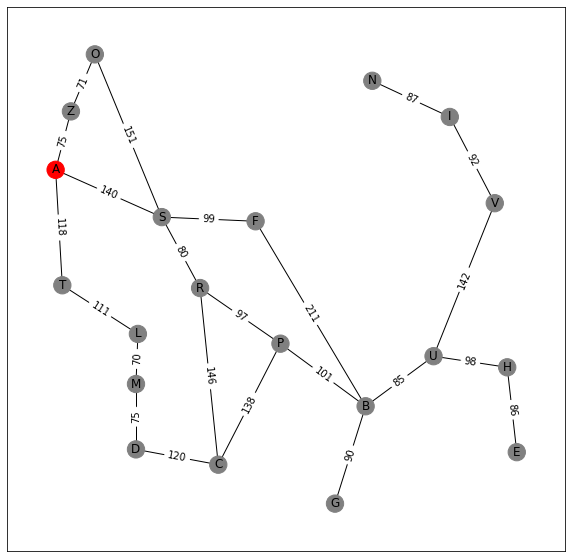

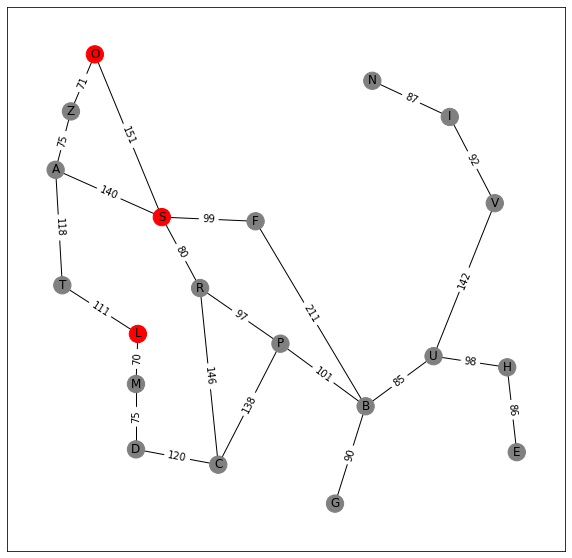

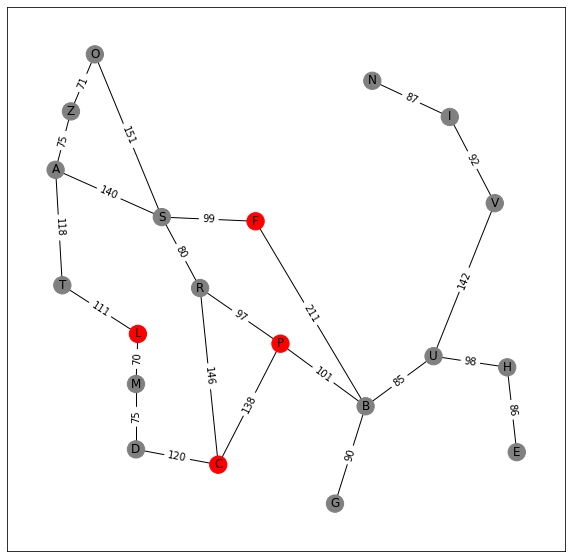

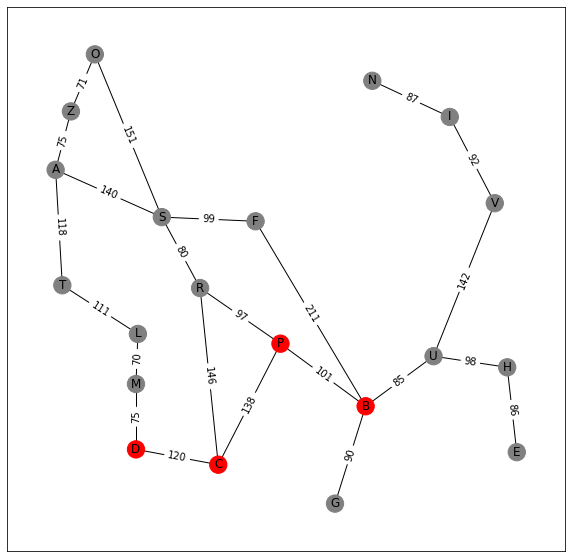

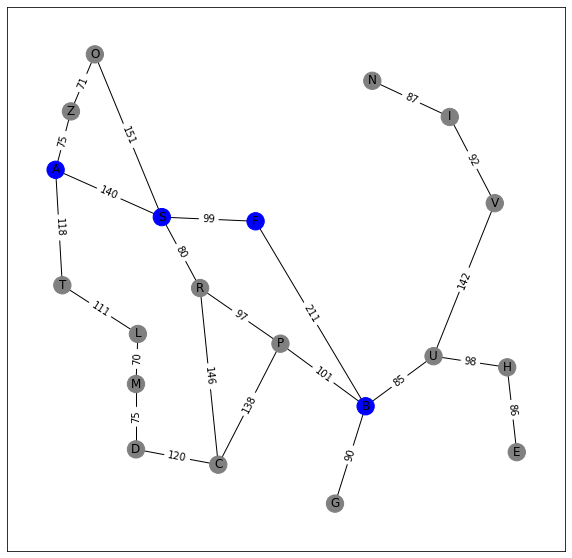

In [28]:
random_problem = RouteProblemNew('A', 'Z', map=random_map_generator())
romania_problem = RouteProblemNew('A', 'B', map=romania)

print(path_states(breadth_first_bfs_visual(romania_problem)))

## BFS
The depiction of the BFS illustrates how the algorihm traverses multiple paths at the same time. Doing so allows the algorithm to find the path with the fewest number of hops, or the lowest cost path when the wieghts are all the same.
Generally, it appears that BFS also keeps a larger frontier than DFS.

['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']


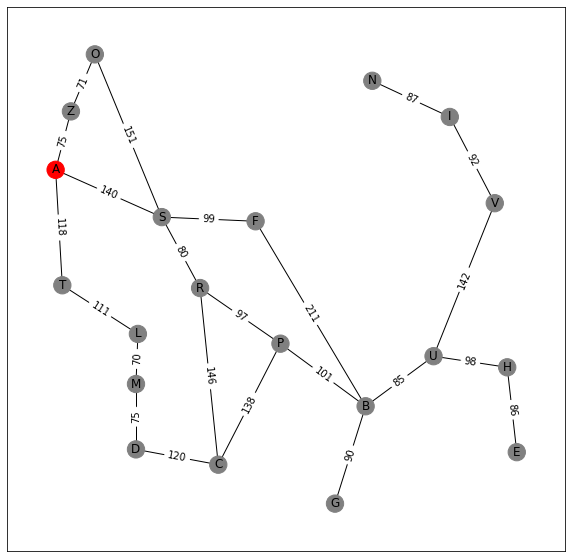

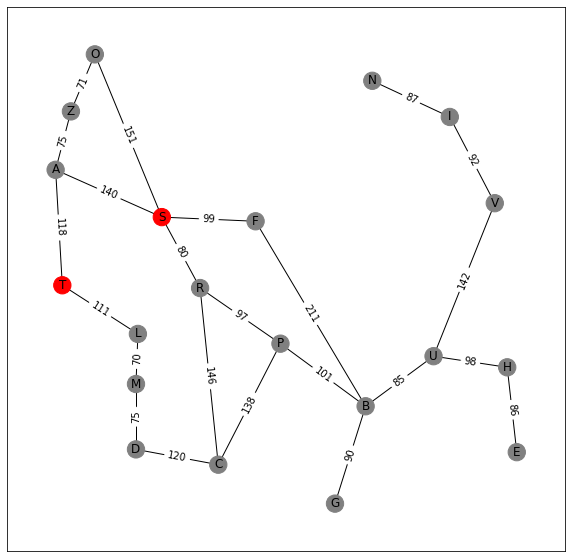

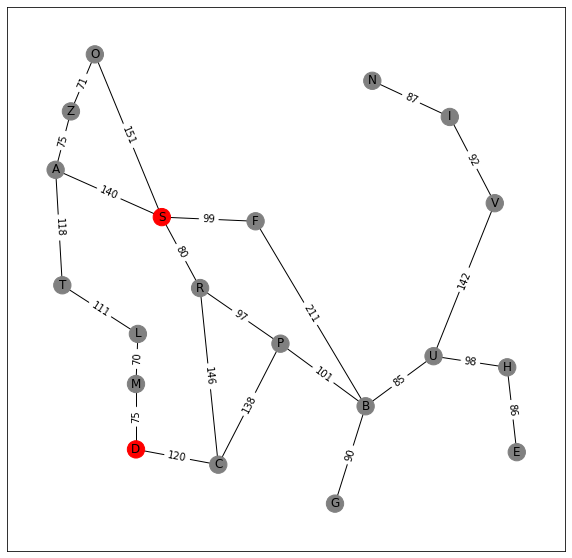

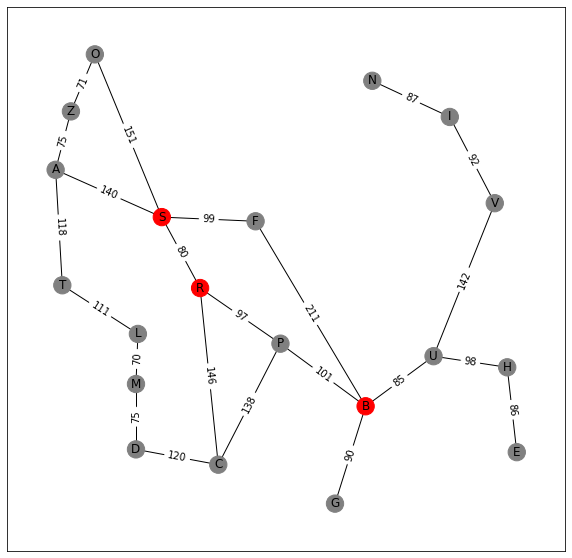

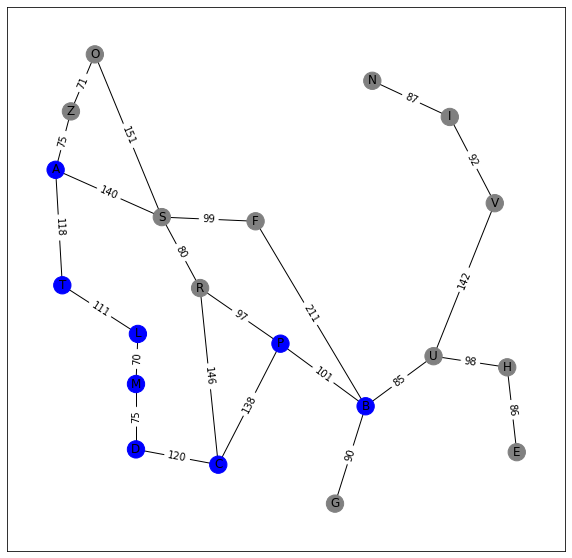

In [29]:
print(path_states(depth_first_bfs_visual(romania_problem)))

## DFS
The DFS algorithm differs from BFS in that it traverses as far as it can down a sinle path before moving on to another. The solution is therefore, not an optimal solution. The tradeoff is that DFS uses less memory.

['A', 'S', 'R', 'P', 'B']


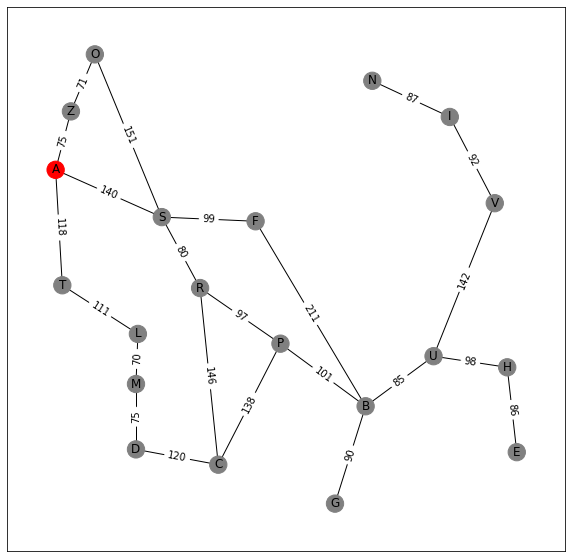

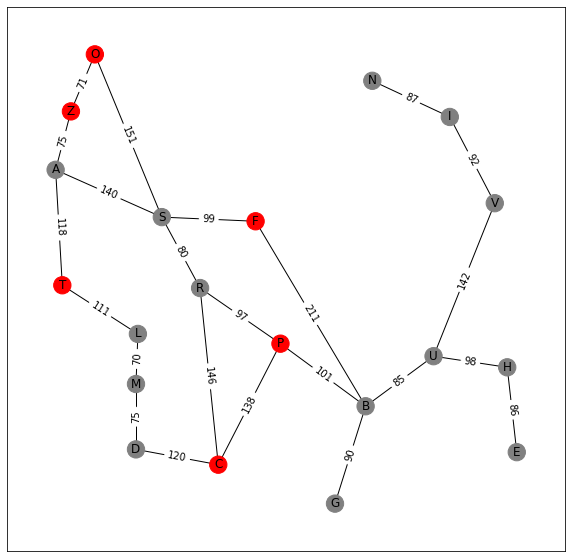

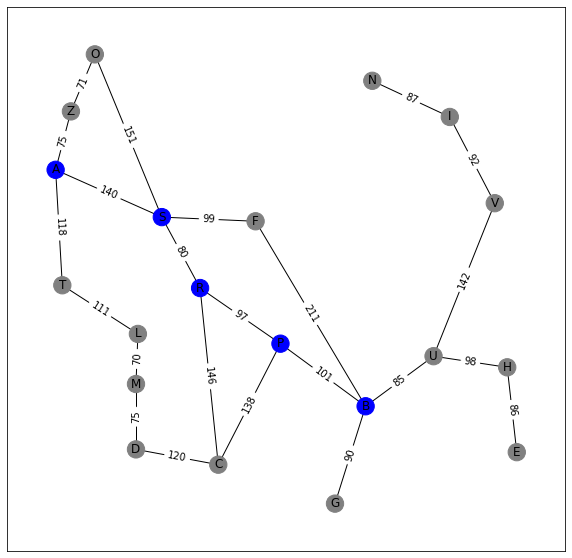

In [30]:
print(path_states(astar_search_visual(romania_problem)))

## $A^*$
This illustration of the $A^*$ search algorithm shows how the algorithm expands the frontier and searches many paths at the same time. Due to the use of an admissable, monotonic heuristic, the found solution is the optimal solution in terms of path cost.
$A^*$ seems to generate the largest frontiers of the three. This is especially visible in the randomly generated graphs below.

['A', 'K', 'H', 'Z']


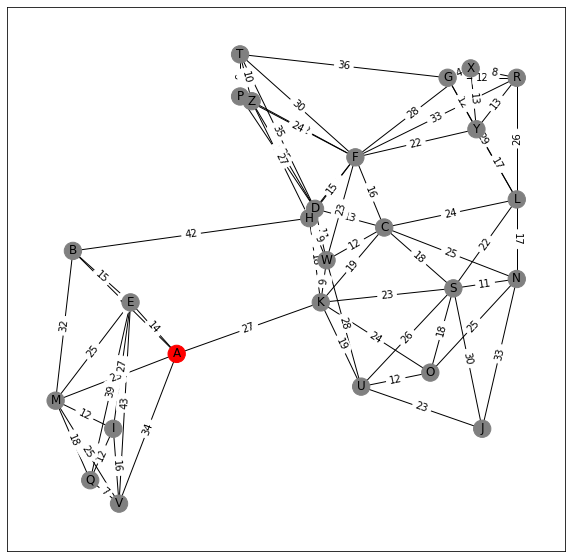

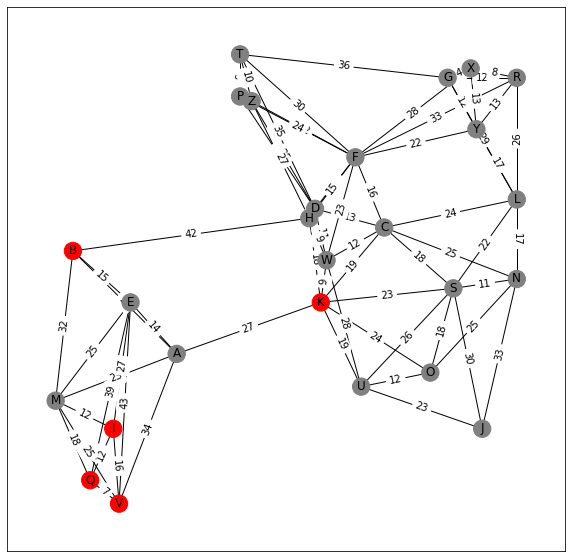

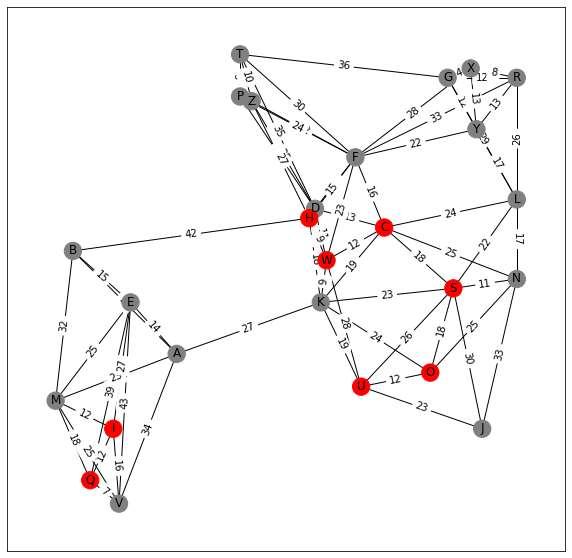

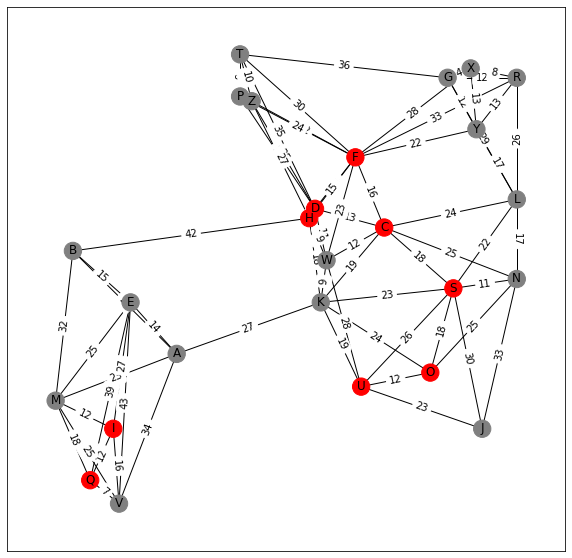

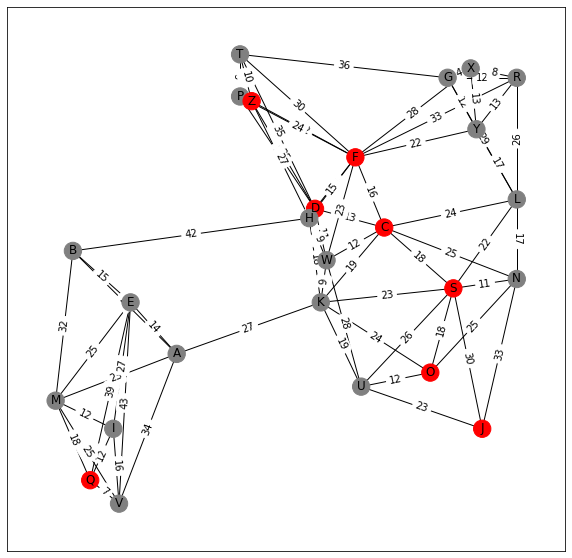

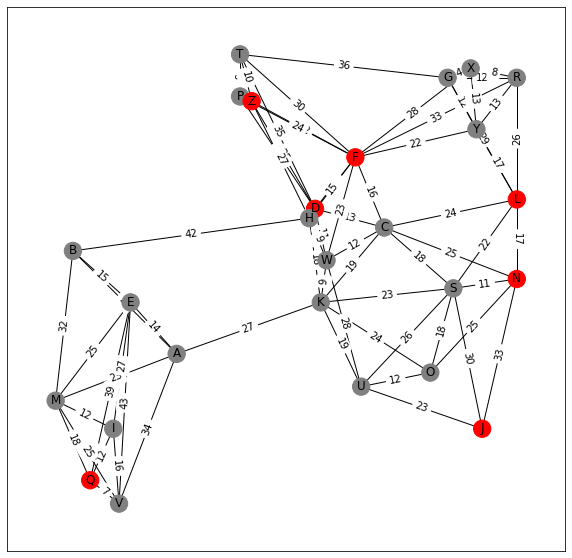

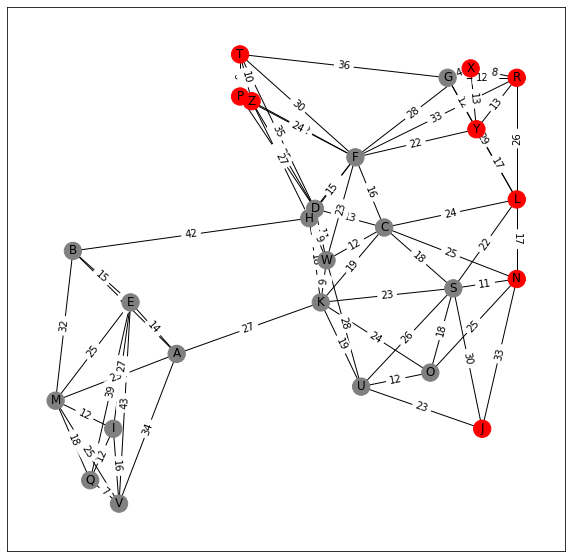

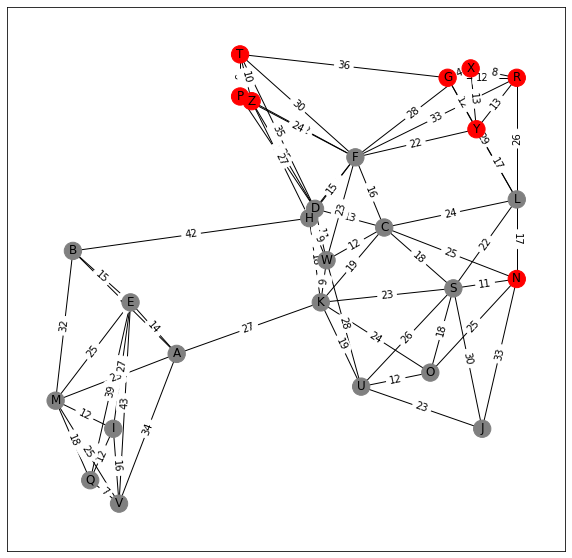

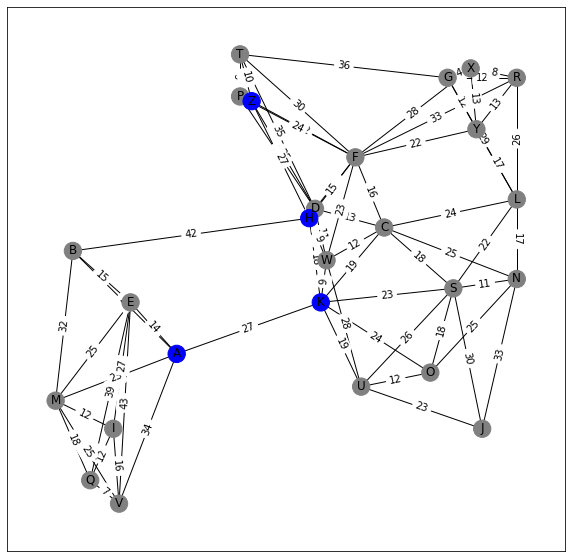

In [31]:
print(path_states(breadth_first_bfs_visual(random_problem)))

['A', 'K', 'W', 'D', 'Z']


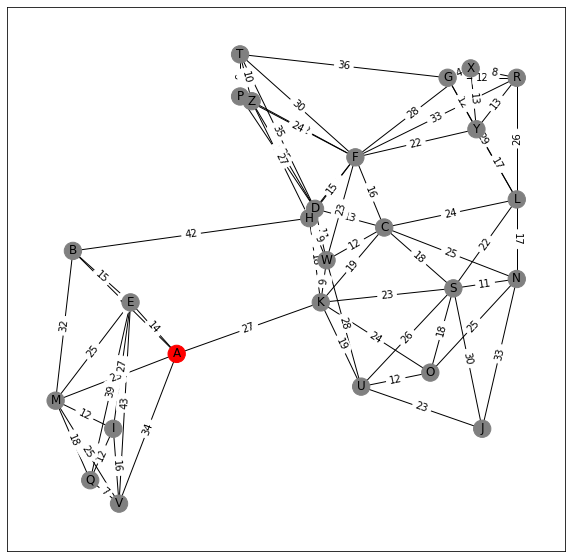

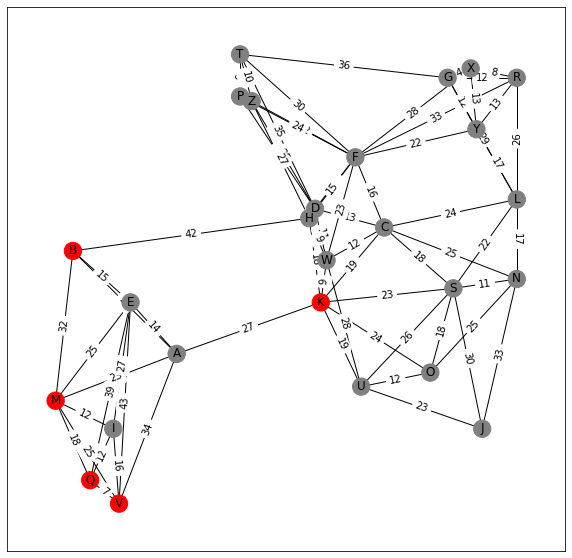

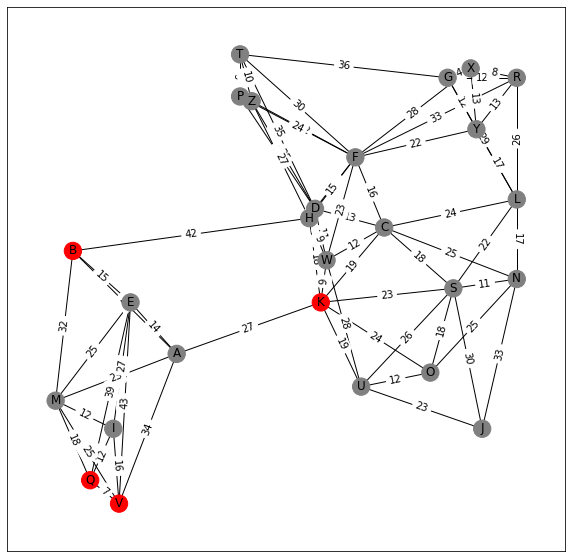

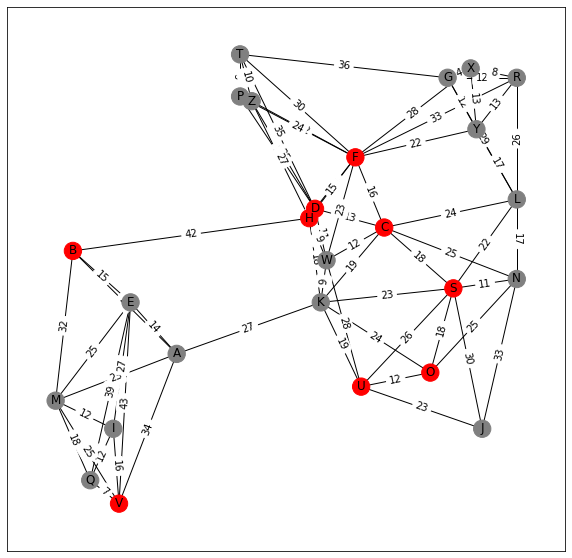

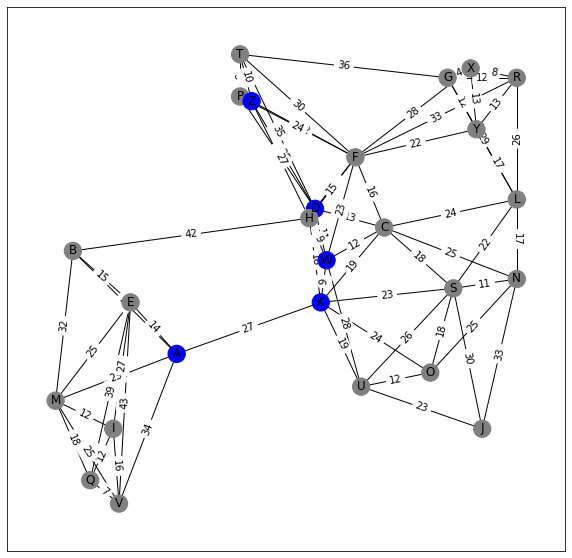

In [32]:
print(path_states(depth_first_bfs_visual(random_problem)))

['A', 'K', 'H', 'Z']


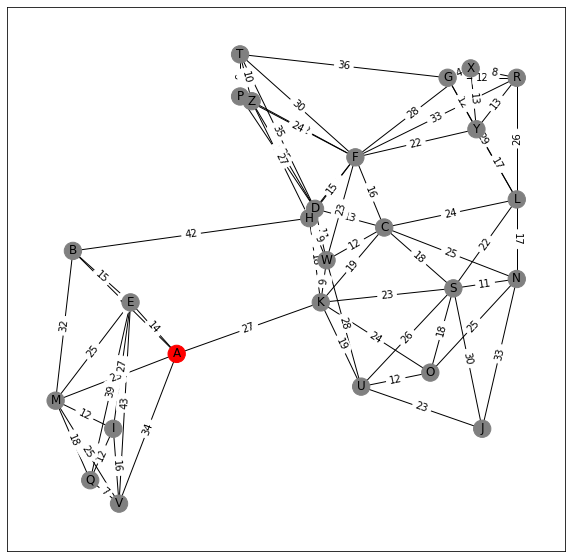

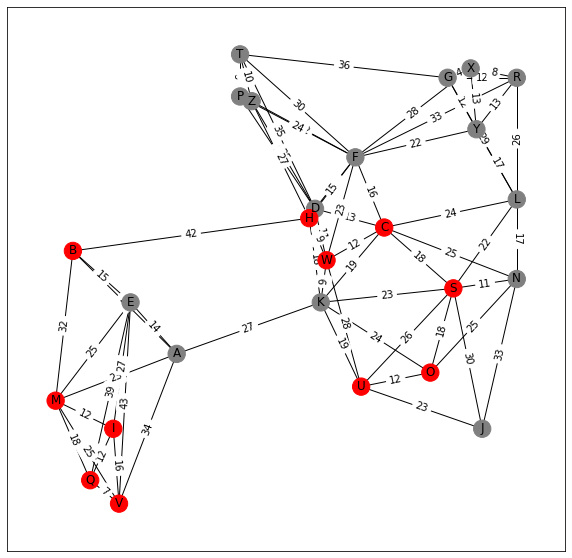

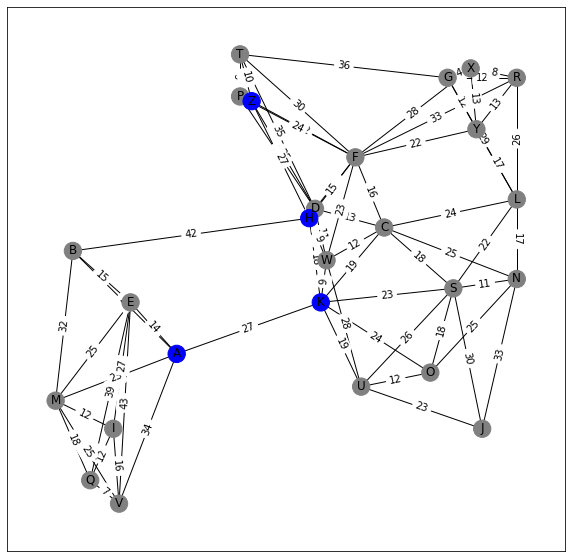

In [33]:
print(path_states(astar_search_visual(random_problem)))

# QUESTION 8 CSP (Basic) 1.0 point 


Let's look at a simple basic implemetation of recursive backgtracking search for solving CSP problems. 

In [34]:
def isComplete(assignment):
    return None not in (assignment.values())

def select_unassigned_variable(variables, assignment):
    for var in variables:
        if assignment[var] is None:
            return var

def is_consistent(assignment, constraints):
    for constraint_violated in constraints:
        if constraint_violated(assignment):
          return False
    return True

def init_assignment(csp):
    assignment = {}
    for var in csp["VARIABLES"]:
        assignment[var] = None
    return assignment

def add_constraint(csp, constraint): 
    csp['CONSTRAINTS'].append(constraint)
    
def recursive_backtracking(assignment, csp):
    if isComplete(assignment):
        return assignment
    var = select_unassigned_variable(csp["VARIABLES"], assignment)
    for value in csp["DOMAINS"]:
        assignment[var] = value
        if is_consistent(assignment, csp["CONSTRAINTS"]):
            result = recursive_backtracking(assignment, csp)
            if result != "FAILURE":
                return result
        assignment[var] = None
    return "FAILURE"

def binary_constraint(var_pair, violations):
    (v1,v2) = var_pair
    return lambda asmt: (asmt[v1], asmt[v2]) in violations

We can use this implementation to solve the Australia map coloring problem. Before working on this question make sure you understand how the code works. 

1. Print the assignment of variables to values during the recursive backtracking search 
2. Suppose that we want to enforce that Westeran Australia (WA) should be blue in our solution. 
Create an initial assignment to pass as the first argument to recursive backtracking to achieve that. 
3. Add a unary constraint function. Similarly to binary constraint it should return a function that takes 
as input an assignment and return true if the assignment violates the constraint. Show how this new unary 
constraint can be used to enforce that WA is blue and T is blue in the resulting solution. 

In [35]:
csp1 = {"VARIABLES": ["WA", "NT", "Q", "NSW", "V", "SA", "T"],
        "DOMAINS": ["red", "green", "blue"],
        "CONSTRAINTS": []}

violations = {('red','red'), ('green','green'), ('blue','blue')}

for (v1,v2) in [('WA', 'NT'), ('WA', 'SA'), 
                ('NT', 'SA'), ('NT', 'Q'), 
                ('SA', 'Q'), ('SA', 'NSW'), 
                ('SA', 'V'),('Q', 'NSW'), 
                ('NSW', 'V')]: 
    add_constraint(csp1, binary_constraint((v1,v2), violations))

result = recursive_backtracking(init_assignment(csp1), csp1)
print('Result', result)


Result {'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'SA': 'blue', 'T': 'red'}


In [36]:
# Q8 ANSWER GOES HERE (modifications to CSP code and definition)

# 1. Print the assignment of variables to values during the recursive backtracking search.
def recursive_backtracking_new(assignment, csp):
    if isComplete(assignment):
        return assignment
    var = select_unassigned_variable(csp["VARIABLES"], assignment)
    for value in csp["DOMAINS"]:
        assignment[var] = value
        print('{} := {}.'.format(var, value))
        if is_consistent(assignment, csp["CONSTRAINTS"]):
            result = recursive_backtracking_new(assignment, csp)
            if result != "FAILURE":
                return result
        assignment[var] = None
    return "FAILURE"

# 2. Suppose that we want to enforce that Westeran Australia (WA) should be blue in our solution. 
#    Create an initial assignment to pass as the first argument to recursive backtracking to achieve that. 
a1 = {}
for var in csp1["VARIABLES"]:
    a1[var] = None
    if var == "WA":
        a1[var] = "blue"

result = recursive_backtracking_new(a1, csp1)
print('Result', result)
print('')

# 3. Add a unary constraint function. Similarly to binary constraint it should return a function that takes as
#    input an assignment and return true if the assignment violates the constraint. Show how this new unary constraint
#    can be used to enforce that WA is blue and T is blue in the resulting solution. 
def unary_constraint(var, violations):
    return lambda assmt: assmt[var] in violations

csp2 = {"VARIABLES": ["WA", "NT", "Q", "NSW", "V", "SA", "T"],
        "DOMAINS": ["red", "green", "blue"],
        "CONSTRAINTS": []}

for (v1,v2) in [('WA', 'NT'), ('WA', 'SA'), 
                ('NT', 'SA'), ('NT', 'Q'), 
                ('SA', 'Q'), ('SA', 'NSW'), 
                ('SA', 'V'),('Q', 'NSW'), 
                ('NSW', 'V')]: 
    add_constraint(csp2, binary_constraint((v1,v2), violations))
    
violations2 = ["red", "green"]
add_constraint(csp2, unary_constraint("WA", violations2))
add_constraint(csp2, unary_constraint("T", violations2))

result = recursive_backtracking_new(init_assignment(csp2), csp2)
print('Result', result)

NT := red.
Q := red.
Q := green.
NSW := red.
V := red.
V := green.
SA := red.
SA := green.
SA := blue.
V := blue.
SA := red.
SA := green.
SA := blue.
NSW := green.
NSW := blue.
V := red.
SA := red.
SA := green.
SA := blue.
V := green.
SA := red.
SA := green.
SA := blue.
V := blue.
Q := blue.
NSW := red.
V := red.
V := green.
SA := red.
SA := green.
SA := blue.
V := blue.
SA := red.
SA := green.
T := red.
Result {'WA': 'blue', 'NT': 'red', 'Q': 'blue', 'NSW': 'red', 'V': 'blue', 'SA': 'green', 'T': 'red'}

WA := red.
WA := green.
WA := blue.
NT := red.
Q := red.
Q := green.
NSW := red.
V := red.
V := green.
SA := red.
SA := green.
SA := blue.
V := blue.
SA := red.
SA := green.
SA := blue.
NSW := green.
NSW := blue.
V := red.
SA := red.
SA := green.
SA := blue.
V := green.
SA := red.
SA := green.
SA := blue.
V := blue.
Q := blue.
NSW := red.
V := red.
V := green.
SA := red.
SA := green.
SA := blue.
V := blue.
SA := red.
SA := green.
T := red.
T := green.
T := blue.
Result {'WA': 'blue', 

# QUESTION 9 CSP (Expected) 1.0 point 

The send more money puzzle is based on the following cryptarithmetic equation: 

&nbsp; SEND<br>
 +MORE<br>
 MONEY<br>
 
Each letter is variable with domain the digits 0-9. Each letter must be assigned a different digit 
in such a way that final assignment satisfies the equation. 


For example here is a solution
 {'S': 9, 'E': 5, 'N': 6, 'D': 7, 'M': 1, 'O': 0, 'R': 8, 'Y': 2}

9567+1085 = 10652


Using the code above express and solve this puzzle. You can define your own constraint function specific 
to this type of problem. 


In [37]:
# Q9 ANSWER GOES HERE (modifications to CSP code and definition)

def crypto_constraint(assignment):
    """
    Reports a constraint violation when SEND + MORE != MONEY. Since addition is only defined for a
    complete assignment, all assignments are considered consistent until proven otherwise.
    """
    if not isComplete(assignment):
        return False
    
    SEND = assignment["S"]*1000 + assignment["E"]*100 + assignment["N"]*10 + assignment["D"]
    MORE = assignment["M"]*1000 + assignment["O"]*100 + assignment["R"]*10 + assignment["E"]
    MONEY = assignment["M"]*10000 + assignment["O"]*1000 + assignment["N"]*100 + assignment["E"]*10 + assignment["Y"]
    
    if SEND + MORE == MONEY:
        return False
    return True

csp3 = {"VARIABLES": ["S", "E", "N", "D", "M", "O", "R", "Y"], \
        "DOMAINS": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], \
        "CONSTRAINTS": []}

# The crypto_constraint determines if an assignment is consistent with the cryptoarithmatic problem.
# The unary constraints are in place to avoid any solutions with leading 0's.
add_constraint(csp3, crypto_constraint)
add_constraint(csp3, unary_constraint("S", [0]))
add_constraint(csp3, unary_constraint("M", [0]))
#add_constraint(csp1, unary_constraint("E", [0]))
# This third unary constraint can be used if a less trivial solution than '9000 + 1000 = 10000' is desired.

# Also this takes a while to compute...
result = recursive_backtracking(init_assignment(csp3), csp3)
print('Result', result)

Result {'S': 9, 'E': 0, 'N': 0, 'D': 0, 'M': 1, 'O': 0, 'R': 0, 'Y': 0}


# QUESTION 10 CSP (Advanced) 1.0 point 

Express solving CSP problems as search problems and use the search algorithm code that is provided 
in this notebook to solve the Australia map problem. The specification of the CSP should use the same 
convention as above but you can transform the provided information as needed to use the search algorithm. 
Show how **BFS** and **DFS** can be used to solve the Australia map coloring problem. Important note: your 
approach should be general and allow the solution of any CSP problem with variables, domains, and constraints 
specified as above. It should **NOT** only solve the Australia map. 

In [38]:
# Q10 
class CspProblem(Problem):
    """
    A problem to find a correct assignment to a set of variables, such that none
    of the stated constraints are violated.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the current assignment of variables; actions are new assignments.
    """
    def __init__(self, csp):
        self.csp = csp
        self.vars = csp["VARIABLES"]
        self.domain = {}
        for var in self.vars:
            self.domain[var] = csp["DOMAINS"]
        self.constraints = csp["CONSTRAINTS"]
        self.initial = Assignment(self.vars, [None for var in self.vars])
        self.seen = []
        
    def actions(self, state): 
        """The possible assignments to attempt."""
        assignments = []
        for var in self.vars:
            if state[var] is None:
                for d in self.domain[var]:
                    assignments.append((var, d))
        
        return assignments
   
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        var, value = action
        n = state.assignment.copy()
        n[var] = value
        return Assignment(n.keys(), n.values())
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return 1
    
    def is_goal(self, state):
        """Goal states are complete assignments that don't violate any constraints."""
        if not isComplete(state.assignment):
            return False
        for constraint_violated in self.constraints:
            if constraint_violated(state.assignment):
                return False

        return True
    
    def prune(self, state):
        """
        Returns True if the state should be pruned from the search tree. Assignments that
        can be shown to be inconsistent don't need to be completed. Since the order of assignmnets
        don't matter, the CSP problem keeps track of the states it has seen and prunes copies of the 
        subtree from further searches.
        """
        for s in self.seen:
            if s.assignment == state.assignment:
                return True
        self.seen.append(state)
        if not is_consistent(state.assignment, self.constraints):
            return True
        return False
    
    def reset_state(self):
        """Reset the problem variables for another search."""
        self.vars = self.csp["VARIABLES"]
        self.domain = {}
        for var in self.vars:
            self.domain[var] = self.csp["DOMAINS"]
        self.constraints = self.csp["CONSTRAINTS"]
        self.initial = Assignment(self.vars, [None for var in self.vars])
        self.seen = []
        
class Assignment:
    """Assignment class for use as states in a CSP search tree."""
    def __init__(self, keys, values=None):
        if values is None:
            values = [None for key in keys]
        self.assignment = dict(zip(keys, values))
    
    def __getitem__(self, key):
        if key not in self.assignment.keys():
            return None
        return self.assignment[key]
    
    def __repr__(self):
        return str(self.assignment)

# Modified to allow for pruning irrelevant subtrees.
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                if problem.prune(s): continue
                frontier.add(child)
    return failure


In [39]:
p1 = CspProblem(csp1)

print('DFS result:')
print(depth_first_bfs(p1).state)
p1.reset_state()
print('')
print('BFS result:')
print(breadth_first_bfs(p1).state)

DFS result:
{'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'SA': 'blue', 'T': 'red'}

BFS result:
{'WA': 'red', 'NT': 'blue', 'Q': 'red', 'NSW': 'blue', 'V': 'red', 'SA': 'green', 'T': 'blue'}
